In [1]:
# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from __future__ import division


import requests
import bs4
import pandas as pd
import numpy as np
import time
import re
import traceback
import pickle
from os.path import exists, isfile, join
from optparse import OptionParser
import os
import json
from collections import OrderedDict
import codecs
from IPython.core.display import display, HTML, Markdown
import py_d3
py_d3.load_ipython_extension(get_ipython())
import seaborn as sns

import treelib
from treelib import Node, Tree
import mistune

import utils

## Статистика

In [2]:
df = pd.read_csv('main_topics.csv')
df

,href,id,title
0,https://glav.su/forum/3/,3,ЭКОНОМИЧЕСКИЙ РАЗДЕЛ
1,https://glav.su/forum/4/,4,ПОЛИТИЧЕСКИЙ РАЗДЕЛ
2,https://glav.su/forum/5/,5,ВОЕННЫЙ РАЗДЕЛ
3,https://glav.su/forum/2/,2,НАУЧНО-ТЕХНИЧЕСКИЙ РАЗДЕЛ
4,https://glav.su/forum/13/,13,ИСТОРИЧЕСКИЙ РАЗДЕЛ
5,https://glav.su/forum/12/,12,АВТОРСКИЙ РАЗДЕЛ
6,https://glav.su/forum/1/,1,ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ
7,https://glav.su/forum/7/,7,ТЕХНИЧЕСКИЙ РАЗДЕЛ


In [3]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'])
print(len(df_topics))

1596


In [4]:
df_topics.head()

,author_id,author_name,href,is_blocked,is_bold,last_datetime,main_tid,tid,title,datetime,tag1,tag2,tag3,tag4
0,20829,Osq,https://glav.su/forum/3/8/,False,True,Вчера в 21:54,3,8,Мировой экономический кризис,2017-12-17 21:54:00,NaN,NaN,NaN,NaN
1,40326,AGROVID.COM,https://glav.su/forum/3/15/,False,True,03.12.17 10:06,3,15,Рынок недвижимости: состояние и перспективы,2017-03-12 10:06:00,NaN,NaN,NaN,NaN
2,40321,Nokia22,https://glav.su/forum/3/2452/,False,True,01.12.17 16:50,3,2452,Санкции в отношении России,2017-01-12 16:50:00,NaN,NaN,NaN,NaN
3,40073,Брустер,https://glav.su/forum/3/777/,False,True,01.12.17 12:44,3,777,Социология и этика кризиса,2017-01-12 12:44:00,NaN,NaN,NaN,NaN
4,18333,Борменталь,https://glav.su/forum/3/206/,False,True,09.09.17 14:09,3,206,FAQ или сборник основных идей,2017-09-09 14:09:00,NaN,NaN,NaN,NaN


/home/.virtualenvs/drivers2/local/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


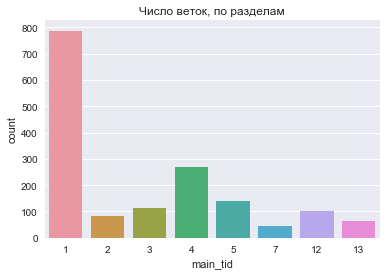

In [5]:
ax = sns.countplot(x='main_tid', data=df_topics)
ax.set_title(u'Число веток, по разделам')
pass

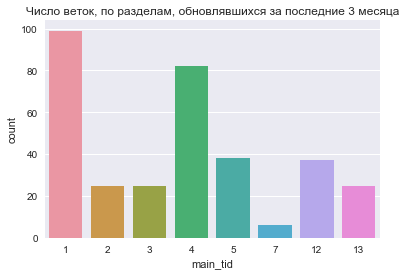

In [6]:
mask = (df_topics['datetime'] > '2017-09-01') & (df_topics['datetime'] <= '2017-12-31')
ax = sns.countplot(x='main_tid', data=df_topics.loc[mask])
ax.set_title(u'Число веток, по разделам, обновлявшихся за последние 3 месяца')
pass

## Проверка соответвия тэгов

Проверка что все тэги, которые прикреплены к веткам, есть в файле описаний дерева категорий.

In [7]:
with codecs.open('tree.md', 'r', 'utf-8') as f:
    tree_md = f.read()
Markdown(tree_md)


- [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
  - Геополитика
    - Россия
      - Кавказ
      - Крым
      - Москва
      - Оппозиция
    - Украина
      - Донбасс
      - Янукович
    - Постсоветское пространство
      - Абхазия
      - Армения
      - Азербайджан
      - Белоруссия
      - Грузия
      - Казахстан
      - Киргизия
      - Молдавия
      - Приднестровье
      - Туркмения
    - Ближний восток
      - Иран
      - Курды
      - Сирия
      - Турция
    - Европа
      - Болгария
      - Великобритания
      - Германия
      - Испания
      - Македония
      - Новороссия
      - Польша
      - Сербия
      - Франция
    - США
    - Другие страны
      - Венесуэла
      - Вьетнам
      - Египет
      - Израиль
      - Индия
      - Ирак
      - Китай
      - КНДР
      - Куба
      - Ливия
      - Пакистан
      - Шотландия
      - Япония
    - БРИКС
    - ООН
  - Общие вопросы, теория
    - Инфраструктура
  - Вооружение
      - НАТО
  - Происшествия
  - Личности
    - Путин
    - Сталин
    - Ходорковский
  - Санкции
  - Наука
    - Космос
  - Информационные войны
  - Помощь
  - Отстойник (и спам)
- [ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ](https://glav.su/forum/1/)
  - ГА
    - Помощь
  - Геополитика
  - Войны
  - Вооружение
  - История
  - Интернет
  - Информационные войны
  - Культура
    - Кино
    - Литература
  - Медицина
  - Наука
    - Школа
    - Климат
    - Космос
    - Образование
  - Новороссия
  - Оппозиция
  - Политика
  - Праздники
    - Новый Год
  - Прогнозирование
  - Происшествия
    - Авиакатастрофы
  - Путин
  - Работа
  - Религия
  - Реформы
  - Спорт
    - Олимпиада
  - Сталин
  - Страны
    - Россия
    - Кавказ
    - Великобритания
    - Европа
    - Египет
    - Китай
    - КНДР
    - Польша
    - Сирия
    - СССР
    - США
    - Украина
  - Хобби
    - Библиография
    - Компьютер
    - Компьютерные игры
    - Луна
    - Программирование
    - Путешествия
    - Фотография
    - Шахматы
  - Философия
  - Экономика
    - Банки
    - Нефтегаз
  - Юмор
  - Отстойник (и спам)
    - Тестирование


In [8]:
tree = utils.parse_tree(tree_md)
#tree.show()

In [9]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'], encoding='utf8')
#df_topics

In [10]:
if False:
    print("Уникальные тэги в исходном файле")
    for tag in utils.get_unique_tags(df_topics):
        print(tag)

In [11]:
absents, indices = utils.check_tags(tree, df_topics)

In [12]:
utils.print_absents(absents, indices, df_topics)

## Построение дерева списка тем

### Исходные данные

In [13]:
with codecs.open('tree.md', 'r', 'utf-8') as f:
    tree_md = f.read()
Markdown(tree_md)

- [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
  - Геополитика
    - Россия
      - Кавказ
      - Крым
      - Москва
      - Оппозиция
    - Украина
      - Донбасс
      - Янукович
    - Постсоветское пространство
      - Абхазия
      - Армения
      - Азербайджан
      - Белоруссия
      - Грузия
      - Казахстан
      - Киргизия
      - Молдавия
      - Приднестровье
      - Туркмения
    - Ближний восток
      - Иран
      - Курды
      - Сирия
      - Турция
    - Европа
      - Болгария
      - Великобритания
      - Германия
      - Испания
      - Македония
      - Новороссия
      - Польша
      - Сербия
      - Франция
    - США
    - Другие страны
      - Венесуэла
      - Вьетнам
      - Египет
      - Израиль
      - Индия
      - Ирак
      - Китай
      - КНДР
      - Куба
      - Ливия
      - Пакистан
      - Шотландия
      - Япония
    - БРИКС
    - ООН
  - Общие вопросы, теория
    - Инфраструктура
  - Вооружение
      - НАТО
  - Происшествия
  - Личности
    - Путин
    - Сталин
    - Ходорковский
  - Санкции
  - Наука
    - Космос
  - Информационные войны
  - Помощь
  - Отстойник (и спам)
- [ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ](https://glav.su/forum/1/)
  - ГА
    - Помощь
  - Геополитика
  - Войны
  - Вооружение
  - История
  - Интернет
  - Информационные войны
  - Культура
    - Кино
    - Литература
  - Медицина
  - Наука
    - Школа
    - Климат
    - Космос
    - Образование
  - Новороссия
  - Оппозиция
  - Политика
  - Праздники
    - Новый Год
  - Прогнозирование
  - Происшествия
    - Авиакатастрофы
  - Путин
  - Работа
  - Религия
  - Реформы
  - Спорт
    - Олимпиада
  - Сталин
  - Страны
    - Россия
    - Кавказ
    - Великобритания
    - Европа
    - Египет
    - Китай
    - КНДР
    - Польша
    - Сирия
    - СССР
    - США
    - Украина
  - Хобби
    - Библиография
    - Компьютер
    - Компьютерные игры
    - Луна
    - Программирование
    - Путешествия
    - Фотография
    - Шахматы
  - Философия
  - Экономика
    - Банки
    - Нефтегаз
  - Юмор
  - Отстойник (и спам)
    - Тестирование


In [14]:
tree = utils.parse_tree(tree_md)
#tree.show()

In [15]:
df = pd.read_csv('main_topics.csv', encoding='utf8')
#df

In [16]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'], encoding='utf8')

In [17]:
absents, indices = utils.check_tags(tree, df_topics)
utils.print_absents(absents, indices, df_topics)

### Построение дерева

Для каждого топика определяем к какой категории(й) дерева он относится, и прикрепляем его


In [18]:
topics_tree = utils.create_topics_tree(tree, df_topics)

Parent node '4 Гаямян' is not in the tree
Parent node '4 Гаямян' is not in the tree


In [19]:
topics_tree.show()

root
├── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
│   ├── Беларусь: проблема геополитического выбора
│   ├── Большой передел мира
│   ├── Вооружение
│   │   ├── Запрещенное видео с беспилотника в Сирии
│   │   ├── Мюнхенская конференция по безопасности 2017
│   │   ├── НАТО
│   │   │   └── Военная операция НАТО в Ливии
│   │   ├── Ракетный удар США по авиабазе в Сирии (07.04.2017)
│   │   └── Что считать оружием в будущем
│   ├── Выбор России: текущая политическая ситуация
│   ├── Выбор США: текущая политическая ситуация
│   ├── Геополитика
│   │   ├── БРИКС
│   │   │   └── БРИКС
│   │   ├── Ближний восток
│   │   │   ├── Арабская весна
│   │   │   ├── Иблиское Государство ДАИШ - нацистский проект
│   │   │   ├── Иран
│   │   │   │   └── Иран и Ближний Восток.
│   │   │   ├── Иран и Ближний Восток.
│   │   │   ├── Крах нео-османской Турции
│   │   │   ├── Курдский фактор
│   │   │   ├── Курды
│   │   │   │   ├── Курдский фактор
│   │   │   │   └── Референдум в Иракском Курдистане
│   │   │   ├── Референдум

### Сохранение в виде markdown

In [20]:
topics_md = utils.topics_tree_2_markdown(topics_tree)

In [21]:
Markdown(topics_md)

  - [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
    - **[Большой передел мира](https://glav.su/forum/4/16/)**
    - **[Перспективы развития России](https://glav.su/forum/4/9/)**
    - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
    - **[Выбор России: текущая политическая ситуация](https://glav.su/forum/4/1340/)**
    - **[Беларусь: проблема геополитического выбора](https://glav.su/forum/4/72/)**
    - **[Пресс-конференция В.В.Путина 14 декабря 2017 года](https://glav.su/forum/4/3237/)**
    - **[Ситуация в Сирии](https://glav.su/forum/4/1624/)**
    - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
    - **[Выбор США: текущая политическая ситуация](https://glav.su/forum/4/46/)**
    - **[Интеграция на постсоветском пространстве: стратегии Российского государства](https://glav.su/forum/4/2183/)**
    - Геополитика
      - Россия
        - **[Перспективы развития России](https://glav.su/forum/4/9/)**
        - **[Выбор России: текущая политическая ситуация](https://glav.su/forum/4/1340/)**
        - [Российский Крым](https://glav.su/forum/4/2376/)
        - [Борьба с коррупцией](https://glav.su/forum/4/1875/)
        - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
        - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
        - [По материалам "ИЗБОРСКОГО КЛУБА", о России, мире, и нашем месте в нём, политика&экономика&социум](https://glav.su/forum/4/2862/)
        - [русская эволюция 5-го марта](https://glav.su/forum/4/1664/)
        - [Расколется ли «ЕдРо»?(см. Известия)  Что важнее-слово данное ДАМ или народу?](https://glav.su/forum/4/1701/)
        - ~~[Глава Хакасии посоветовал бедным муниципалитетам варить тушенку](https://glav.su/forum/4/3212/)~~
        - ~~[Депутат Госдумы записала клип о готовности детей умереть за Путина](https://glav.su/forum/4/3211/)~~
        - [Крушение Ту-154](https://glav.su/forum/4/2989/)
        - ~~[Нужен всероссийский «мозговой штурм» к столетию Февральской и Октябрьской революций](https://glav.su/forum/4/3050/)~~
        - ~~[Национальный вопрос в России](https://glav.su/forum/4/1436/)~~
        - ~~[Работники Высшей Школы Экономики попали в эпицентр гомосексуального скандала](https://glav.su/forum/4/3198/)~~
        - ~~[Как прошли митинги в поддержку Навального?](https://glav.su/forum/4/3184/)~~
        - [Реформа РАН](https://glav.su/forum/4/2180/)
        - [Будет ли новая смута в России?](https://glav.su/forum/4/3164/)
        - [ Жизнь Российского Телемедийного пространства](https://glav.su/forum/4/2117/)
        - ~~[Чей Крым](https://glav.su/forum/4/3156/)~~
        - ~~[Роковая ошибка Сталина](https://glav.su/forum/4/3154/)~~
        - [Феномен Сталина](https://glav.su/forum/4/3140/)
        - ~~[Перспективы развития России - 2](https://glav.su/forum/4/3126/)~~
        - [Разговор оппозиционера с охранителем](https://glav.su/forum/4/1735/)
        - [Терешкова](https://glav.su/forum/4/3115/)
        - [Госдума РФ](https://glav.su/forum/4/3114/)
        - [Кому выгоден раскол общества в России и в мире?](https://glav.su/forum/4/2971/)
        - [Радио Глобальной Авантюры](https://glav.su/forum/4/1776/)
        - [Радикализм и экстремизм несистемной оппозиции](https://glav.su/forum/4/1592/)
        - [В Симферополе затопило несколько районов из-за ливня .Ето оружие климата как вы считаете](https://glav.su/forum/4/3100/)
        - [Эмиграция и репатриация в Россию](https://glav.su/forum/4/11/)
        - [Взрыв в метро Санкт-Петербурга (03.04.2017)](https://glav.su/forum/4/3066/)
        - ~~[О том как у нас сажают на основании доносов. Свежий пример.](https://glav.su/forum/4/3073/)~~
        - [На пороге отмены санкций против России](https://glav.su/forum/4/3072/)
        - [Визит Тиллерсона в Москву (12.04.2017)](https://glav.su/forum/4/3070/)
        - [Убийство Дениса Вороненкова в Киеве](https://glav.su/forum/4/3054/)
        - ~~[Митинги оппозиции за отставку Медведева (26.03.2017)](https://glav.su/forum/4/3057/)~~
        - ~~[Демократический манифест 2017](https://glav.su/forum/4/3051/)~~
        - [Есть ли жизнь от Урала до Дальнего Востока?](https://glav.su/forum/4/1857/)
        - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
        - [Умер представитель России при ООН Виталий Чуркин](https://glav.su/forum/4/3037/)
        - [России нужна новая идеология](https://glav.su/forum/4/1222/)
        - [Убийство Гиви](https://glav.su/forum/4/3018/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Модернизация России](https://glav.su/forum/4/3020/)
        - [Что принадлежит русским в России?](https://glav.su/forum/4/2908/)
        - ~~[Всё пропало](https://glav.su/forum/4/3005/)~~
        - [Большая пресс-конференция с Владимиром Путиным (23.12.2016)](https://glav.su/forum/4/2987/)
        - [Кто правит бал на ТВ мракобесы и невежды 90х или народ?! С подачи жж М.Шевченко](https://glav.su/forum/4/1698/)
        - ~~[Карго-культ в РФ](https://glav.su/forum/4/2910/)~~
        - [Донбасс - его жизнь и судьба](https://glav.su/forum/4/2658/)
        - [Мемориал НОВОРОССИИ](https://glav.su/forum/4/2460/)
        - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
        - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
        - [Закавказья и Дагестан - автохтонные народы.](https://glav.su/forum/4/2229/)
        - [Алкогольная политика и демография](https://glav.su/forum/4/1389/)
        - [Прямая линия с Владимиром Путиным (14.04.2016)](https://glav.su/forum/4/2816/)
        - [Объективно и Сталин](https://glav.su/forum/4/2813/)
        - ~~[Объективно и Сталин](https://glav.su/forum/4/2812/)~~
        - [Большая пресс-конференция с Владимиром Путиным (17.12.2015)](https://glav.su/forum/4/2744/)
        - [Украинско-российские отношения](https://glav.su/forum/4/2434/)
        - ~~[Санация санкциями. Империя наносит ответный удар](https://glav.su/forum/4/2468/)~~
        - [Вопросы возвращения потерянных земель России](https://glav.su/forum/4/852/)
        - [За что должен сидеть Ходорковский](https://glav.su/forum/4/2348/)
        - [Прямая линия с Владимиром Путиным (16.04.2015)](https://glav.su/forum/4/2622/)
        - [Прямая линия с Владимиром Путиным (25.04.2013)](https://glav.su/forum/4/2143/)
        - [Следущий Президент России](https://glav.su/forum/4/2593/)
        - [Конституция. Реформа нужна?](https://glav.su/forum/4/2588/)
        - [Выборы мэра Москвы](https://glav.su/forum/4/2235/)
        - [Отношения России и США](https://glav.su/forum/4/2522/)
        - [Волгоград в Сталинград?](https://glav.su/forum/4/2429/)
        - [Путин: Новая Национальная Идея](https://glav.su/forum/4/2263/)
        - [Сколько заплатили Немцову, Акунину,чириковой, навальному?](https://glav.su/forum/4/1569/)
        - Кавказ
          - [Закавказья и Дагестан - автохтонные народы.](https://glav.su/forum/4/2229/)
        - Крым
          - [Российский Крым](https://glav.su/forum/4/2376/)
          - ~~[Чей Крым](https://glav.su/forum/4/3156/)~~
          - [В Симферополе затопило несколько районов из-за ливня .Ето оружие климата как вы считаете](https://glav.su/forum/4/3100/)
          - [Референдум по вхождению областей Украины в Автономную Республику Крым](https://glav.su/forum/4/2367/)
        - Москва
          - [Выборы мэра Москвы](https://glav.su/forum/4/2235/)
        - Оппозиция
          - [Радикализм и экстремизм несистемной оппозиции](https://glav.su/forum/4/1592/)
          - ~~[Митинги оппозиции за отставку Медведева (26.03.2017)](https://glav.su/forum/4/3057/)~~
          - [За что должен сидеть Ходорковский](https://glav.su/forum/4/2348/)
          - [Сколько заплатили Немцову, Акунину,чириковой, навальному?](https://glav.su/forum/4/1569/)
      - Украина
        - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
        - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
        - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
        - [Катастрофа Boeing MH17 под Донецком](https://glav.su/forum/4/2685/)
        - [Реинтеграция Украины: авантюрные стратегии](https://glav.su/forum/4/2146/)
        - [Украина. Закон об образовании 2017.](https://glav.su/forum/4/3210/)
        - [Прорыв Саакашвили на Украину](https://glav.su/forum/4/3152/)
        - [Проект Фашистская Украина.](https://glav.su/forum/4/2365/)
        - [Я Украинец и Я люблю Газманова но мне запрещают слушать его(((](https://glav.su/forum/4/3113/)
        - [Убийство Дениса Вороненкова в Киеве](https://glav.su/forum/4/3054/)
        - [Взрыв арсенала в Балаклее Харьковской области](https://glav.su/forum/4/3055/)
        - [Убийство Гиви](https://glav.su/forum/4/3018/)
        - [Брожение украинских умов](https://glav.su/forum/4/2824/)
        - [Некое предложение для отрезвления "украинцев"](https://glav.su/forum/4/2891/)
        - [Донбасс - его жизнь и судьба](https://glav.su/forum/4/2658/)
        - [Мемориал НОВОРОССИИ](https://glav.su/forum/4/2460/)
        - ["Правый Сектор"](https://glav.su/forum/4/2785/)
        - [Украинско-российские отношения](https://glav.su/forum/4/2434/)
        - ~~[Пресс-конференция с Глебом Бобровым "Украина: Эпоха мертворожденных?"](https://glav.su/forum/4/2444/)~~
        - [МАЙДАН - духовное объяснение.](https://glav.su/forum/4/2386/)
        - [Хроники евромайдана.](https://glav.su/forum/4/2375/)
        - [Интервью Януковича](https://glav.su/forum/4/2370/)
        - [Референдум по вхождению областей Украины в Автономную Республику Крым](https://glav.su/forum/4/2367/)
        - [К Евромайдану присоединились татарские исламисты](https://glav.su/forum/4/2363/)
        - Донбасс
          - ~~[Бывший аналитик ЦРУ о ситуации в Донбассе и действиях Путина!](https://glav.su/forum/4/2578/)~~
        - Янукович
          - [Интервью Януковича](https://glav.su/forum/4/2370/)
      - Постсоветское пространство
        - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
        - **[Интеграция на постсоветском пространстве: стратегии Российского государства](https://glav.su/forum/4/2183/)**
        - [Беларусь. Непредвзято.](https://glav.su/forum/4/3093/)
        - [Казахстан & С А](https://glav.su/forum/4/432/)
        - [Среднеазиатский капкан. Киргизия и др.](https://glav.su/forum/4/990/)
        - [При(-о)@балтика](https://glav.su/forum/4/166/)
        - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
        - [Азербайджан сегодня](https://glav.su/forum/4/2589/)
        - [Армения](https://glav.su/forum/4/2177/)
        - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
        - ~~[Армения и ось Москва-тегеран](https://glav.su/forum/4/3155/)~~
        - [Грузинский гондурас.](https://glav.su/forum/4/150/)
        - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
        - [Украина. Закон об образовании 2017.](https://glav.su/forum/4/3210/)
        - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
        - [Туркмения.](https://glav.su/forum/4/1440/)
        - [Молдавия](https://glav.su/forum/4/435/)
        - [Проект Фашистская Украина.](https://glav.su/forum/4/2365/)
        - [Я Украинец и Я люблю Газманова но мне запрещают слушать его(((](https://glav.su/forum/4/3113/)
        - [Абхазия и Южная Осетия: Под сенью дружеских штыков?](https://glav.su/forum/4/1557/)
        - [Приднестровье](https://glav.su/forum/4/1585/)
        - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
        - [Армянский (и не только) опыт выжывания](https://glav.su/forum/4/2471/)
        - Абхазия
          - [Абхазия и Южная Осетия: Под сенью дружеских штыков?](https://glav.su/forum/4/1557/)
        - Армения
          - [Армения](https://glav.su/forum/4/2177/)
          - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
          - ~~[Армения и ось Москва-тегеран](https://glav.su/forum/4/3155/)~~
          - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
          - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
          - [Армянский (и не только) опыт выжывания](https://glav.su/forum/4/2471/)
        - Азербайджан
          - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
          - [Азербайджан сегодня](https://glav.su/forum/4/2589/)
          - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
          - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
        - Белоруссия
          - **[Беларусь: проблема геополитического выбора](https://glav.su/forum/4/72/)**
          - [Беларусь. Непредвзято.](https://glav.su/forum/4/3093/)
        - Грузия
          - [Грузинский гондурас.](https://glav.su/forum/4/150/)
        - Казахстан
          - [Казахстан & С А](https://glav.su/forum/4/432/)
        - Киргизия
          - [Среднеазиатский капкан. Киргизия и др.](https://glav.su/forum/4/990/)
        - Молдавия
          - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
          - [Молдавия](https://glav.su/forum/4/435/)
        - Приднестровье
          - [Приднестровье](https://glav.su/forum/4/1585/)
        - Туркмения
          - [Туркмения.](https://glav.su/forum/4/1440/)
      - Ближний восток
        - [Иран и Ближний Восток.](https://glav.su/forum/4/155/)
        - [Турция сегодня](https://glav.su/forum/4/2846/)
        - [Курдский фактор](https://glav.su/forum/4/2050/)
        - [Арабская весна](https://glav.su/forum/4/1437/)
        - [Крах нео-османской Турции](https://glav.su/forum/4/2161/)
        - [Референдум в Иракском Курдистане](https://glav.su/forum/4/3173/)
        - [Иблиское Государство ДАИШ - нацистский проект](https://glav.su/forum/4/2581/)
        - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
        - Иран
          - [Иран и Ближний Восток.](https://glav.su/forum/4/155/)
        - Курды
          - [Курдский фактор](https://glav.su/forum/4/2050/)
          - [Референдум в Иракском Курдистане](https://glav.su/forum/4/3173/)
        - Сирия
          - **[Ситуация в Сирии](https://glav.su/forum/4/1624/)**
          - ~~[Сирийские хроники](https://glav.su/forum/4/1547/)~~
          - ~~[Запрещенное видео с беспилотника в Сирии](https://glav.su/forum/4/2718/)~~
          - [Сирийская лжевойна](https://glav.su/forum/4/2259/)
        - Турция
          - [Турция сегодня](https://glav.su/forum/4/2846/)
          - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
          - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
          - [Крах нео-османской Турции](https://glav.su/forum/4/2161/)
          - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
          - [Саммит G20 в Анталье 2015](https://glav.su/forum/4/2728/)
      - Европа
        - **[Саморазрушение Европы - конец Старого Света?](https://glav.su/forum/4/1724/)**
        - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
        - [...плюс-минус газификация всей Европы](https://glav.su/forum/4/366/)
        - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
        - [Бежнцы, и стратегическая ошибка Европы](https://glav.su/forum/4/3138/)
        - [Европейские монархии](https://glav.su/forum/4/2209/)
        - [Северная Европа](https://glav.su/forum/4/1838/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - Болгария
          - [Болгарский  Перец](https://glav.su/forum/4/965/)
        - Великобритания
          - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
          - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
          - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
          - [Теракт в Лондоне 22.03.2017](https://glav.su/forum/4/3056/)
        - Германия
          - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - Испания
          - [Движение за независимость Каталонии](https://glav.su/forum/4/3151/)
          - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - Македония
          - [Политический кризис в Македонии](https://glav.su/forum/4/2649/)
        - Новороссия
          - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
          - [Катастрофа Boeing MH17 под Донецком](https://glav.su/forum/4/2685/)
          - ~~[Бывший аналитик ЦРУ о ситуации в Донбассе и действиях Путина!](https://glav.su/forum/4/2578/)~~
          - [Славянск: вид из операционной хирургического отделения ЦКБ](https://glav.su/forum/4/2441/)
        - Польша
          - [Польша: Яблочная Революция "гонор"](https://glav.su/forum/4/2982/)
        - Сербия
          - [Сербия и б. Югославия](https://glav.su/forum/4/1387/)
        - Франция
          - [Выборы  во ФРАНЦИИ,  vivre ou ne pas vivre!!!???](https://glav.su/forum/4/3022/)
          - [Теракт в Париже](https://glav.su/forum/4/2726/)
          - [Выборы президента Франции 2017](https://glav.su/forum/4/2998/)
          - [Теракт в Ницце](https://glav.su/forum/4/2860/)
      - США
        - **[Выбор США: текущая политическая ситуация](https://glav.su/forum/4/46/)**
        - [Полный список всех военных преступлений Соединённых Штатов Америки.](https://glav.su/forum/4/1709/)
        - [Сетевые войны: США жалуются на победу России](https://glav.su/forum/4/3149/)
        - [Инагурация 45-го президента США Дональда Трампа](https://glav.su/forum/4/3004/)
        - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
        - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
        - [Визит Тиллерсона в Москву (12.04.2017)](https://glav.su/forum/4/3070/)
        - ~~[Переворот в США назначен на 1 мая?](https://glav.su/forum/4/3049/)~~
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Пятый элемент. США: глобальная ложь.](https://glav.su/forum/4/2991/)
        - [Бывший ЦРУшник: " Не Россия - враг Америки. Реальная угроза исходит от Израиля!"](https://glav.su/forum/4/2979/)
        - [История геноцида индейцев  режимом США глазами американцев](https://glav.su/forum/4/2898/)
        - [Наша Аляска](https://glav.su/forum/4/2395/)
        - [Отношения России и США](https://glav.su/forum/4/2522/)
        - [Преступления США всплывают одно за другим.](https://glav.su/forum/4/2521/)
        - [Американская революция 2.0](https://glav.su/forum/4/1344/)
        - [Латинская Америка не хочет быть казармой США    Нил НИКАНДРОВ](https://glav.su/forum/4/2436/)
      - Другие страны
        - [Израиль, как Вселенная.Еврейский вопрос -  от Абрама до Абрамовича.](https://glav.su/forum/4/635/)
        - [Турция сегодня](https://glav.su/forum/4/2846/)
        - [Польша: Яблочная Революция "гонор"](https://glav.su/forum/4/2982/)
        - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
        - [Напряженность на Корейском полуострове](https://glav.su/forum/4/984/)
        - [Япония](https://glav.su/forum/4/855/)
        - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
        - [Полный список всех военных преступлений Соединённых Штатов Америки.](https://glav.su/forum/4/1709/)
        - [Движение за независимость Каталонии](https://glav.su/forum/4/3151/)
        - [За Китай](https://glav.su/forum/4/123/)
        - [Правильные вопросы про Северную Корею](https://glav.su/forum/4/2798/)
        - [...плюс-минус газификация всей Европы](https://glav.su/forum/4/366/)
        - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
        - [Бежнцы, и стратегическая ошибка Европы](https://glav.su/forum/4/3138/)
        - [БРИКС](https://glav.su/forum/4/2671/)
        - [Ситуация в Венесуэле](https://glav.su/forum/4/3082/)
        - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
        - [Европейские монархии](https://glav.su/forum/4/2209/)
        - [Инагурация 45-го президента США Дональда Трампа](https://glav.su/forum/4/3004/)
        - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
        - [Выборы  во ФРАНЦИИ,  vivre ou ne pas vivre!!!???](https://glav.su/forum/4/3022/)
        - [Теракт в Париже](https://glav.su/forum/4/2726/)
        - [Теракт в Лондоне 22.03.2017](https://glav.su/forum/4/3056/)
        - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
        - [Политический кризис в Македонии](https://glav.su/forum/4/2649/)
        - [Ирак - ящик пандоры](https://glav.su/forum/4/2432/)
        - [Золотая Звезда Вьетнама](https://glav.su/forum/4/2422/)
        - [Северная Европа](https://glav.su/forum/4/1838/)
        - [Выборы президента Франции 2017](https://glav.su/forum/4/2998/)
        - [Станет ли Израиль удаленным штатом США?](https://glav.su/forum/4/3079/)
        - [Сербия и б. Югославия](https://glav.su/forum/4/1387/)
        - [Болгарский  Перец](https://glav.su/forum/4/965/)
        - ~~[Переворот в США назначен на 1 мая?](https://glav.su/forum/4/3049/)~~
        - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Мартовская катастрофа в Японии](https://glav.su/forum/4/1431/)
        - [Пятый элемент. США: глобальная ложь.](https://glav.su/forum/4/2991/)
        - [Перед бурей...](https://glav.su/forum/4/2983/)
        - [Куба](https://glav.su/forum/4/1170/)
        - [История геноцида индейцев  режимом США глазами американцев](https://glav.su/forum/4/2898/)
        - [Не ходите, дети, в Африку гулять...](https://glav.su/forum/4/1348/)
        - [Теракт в Ницце](https://glav.su/forum/4/2860/)
        - ~~[Сирийские хроники](https://glav.su/forum/4/1547/)~~
        - [Смена власти в Египте](https://glav.su/forum/4/2188/)
        - [Куба и латинская Америка](https://glav.su/forum/4/2628/)
        - [Цыгане в мире](https://glav.su/forum/4/2804/)
        - [Катастрофа А321 Когалымавиа на Синае](https://glav.su/forum/4/2722/)
        - [Саммит G20 в Анталье 2015](https://glav.su/forum/4/2728/)
        - ~~[Запрещенное видео с беспилотника в Сирии](https://glav.su/forum/4/2718/)~~
        - ~~[Падение самолета на Синае: факты,  версии](https://glav.su/forum/4/2721/)~~
        - [Преступления США всплывают одно за другим.](https://glav.su/forum/4/2521/)
        - [Латинская Америка не хочет быть казармой США    Нил НИКАНДРОВ](https://glav.su/forum/4/2436/)
        - [Военный переворот в Таиланде](https://glav.su/forum/4/2418/)
        - Венесуэла
          - [Ситуация в Венесуэле](https://glav.su/forum/4/3082/)
        - Вьетнам
          - [Золотая Звезда Вьетнама](https://glav.su/forum/4/2422/)
        - Египет
          - [Смена власти в Египте](https://glav.su/forum/4/2188/)
          - ~~[Падение самолета на Синае: факты,  версии](https://glav.su/forum/4/2721/)~~
        - Израиль
          - [Израиль, как Вселенная.Еврейский вопрос -  от Абрама до Абрамовича.](https://glav.su/forum/4/635/)
          - [Станет ли Израиль удаленным штатом США?](https://glav.su/forum/4/3079/)
          - [Бывший ЦРУшник: " Не Россия - враг Америки. Реальная угроза исходит от Израиля!"](https://glav.su/forum/4/2979/)
        - Индия
          - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - Ирак
          - [Ирак - ящик пандоры](https://glav.su/forum/4/2432/)
        - Китай
          - [За Китай](https://glav.su/forum/4/123/)
        - КНДР
          - [Напряженность на Корейском полуострове](https://glav.su/forum/4/984/)
          - [Правильные вопросы про Северную Корею](https://glav.su/forum/4/2798/)
        - Куба
          - [Куба](https://glav.su/forum/4/1170/)
          - [Куба и латинская Америка](https://glav.su/forum/4/2628/)
        - Ливия
          - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
        - Пакистан
          - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - Шотландия
          - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
        - Япония
          - [Япония](https://glav.su/forum/4/855/)
          - [Мартовская катастрофа в Японии](https://glav.su/forum/4/1431/)
      - БРИКС
        - [БРИКС](https://glav.su/forum/4/2671/)
      - ООН
        - [Умер представитель России при ООН Виталий Чуркин](https://glav.su/forum/4/3037/)
    - Общие вопросы, теория
      - [Геополитика в строительстве нации: политические аспекты этнической самоидентификации](https://glav.su/forum/4/2448/)
      - [Государство и Религия.](https://glav.su/forum/4/3000/)
      - [Информационные войны](https://glav.su/forum/4/165/)
      - [ Социализм-коммунизм и левая идея в целом](https://glav.su/forum/4/368/)
      - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
      - [Реинтеграция Украины: авантюрные стратегии](https://glav.su/forum/4/2146/)
      - [По материалам "ИЗБОРСКОГО КЛУБА", о России, мире, и нашем месте в нём, политика&экономика&социум](https://glav.su/forum/4/2862/)
      - [Что считать оружием в будущем](https://glav.su/forum/4/3064/)
      - [Терроризм и борьба с ним](https://glav.su/forum/4/982/)
      - [ГЛОБАльная ванГА: Глупец, хотел уверить нас, Что бог гласит его устами!](https://glav.su/forum/4/2737/)
      - [Инфраструктура и транспорт как элемент геополитики](https://glav.su/forum/4/1073/)
      - ~~[требуется новая идеология , которая может идеологически объединить практически всех людей нашей стра](https://glav.su/forum/4/3176/)~~
      - [Критика  либерализма](https://glav.su/forum/4/3158/)
      - [Разговор оппозиционера с охранителем](https://glav.su/forum/4/1735/)
      - [Мюнхенская конференция по безопасности 2017](https://glav.su/forum/4/3034/)
      - [России нужна новая идеология](https://glav.su/forum/4/1222/)
      - [Модернизация России](https://glav.su/forum/4/3020/)
      - [Энергетическая Геополитика: на вопросы отвечает Already Yet](https://glav.su/forum/4/2151/)
      - [Про демократию, Россию и США, а так же немного про жизнь.](https://glav.su/forum/4/1061/)
      - ["Инновационный новый политический концепт. Начала Новой Политэкономии, Гармонизм (от слова гармония)](https://glav.su/forum/4/2783/)
      - [Переход от стратегических «звездных войн» к тактическим «сырным операциям»…](https://glav.su/forum/4/1717/)
      - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
      - [Алкогольная политика и демография](https://glav.su/forum/4/1389/)
      - [Совершенное рабство.](https://glav.su/forum/4/2810/)
      - [Конституция. Реформа нужна?](https://glav.su/forum/4/2588/)
      - [Самый преступный закон цивилизации](https://glav.su/forum/4/2585/)
      - [Новая философская идея](https://glav.su/forum/4/2490/)
      - [Основы Геополитики. Остров-Материк. Огненная Дуга.](https://glav.su/forum/4/2433/)
      - Инфраструктура
        - [Инфраструктура и транспорт как элемент геополитики](https://glav.su/forum/4/1073/)
    - Вооружение
      - [Что считать оружием в будущем](https://glav.su/forum/4/3064/)
      - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
      - [Мюнхенская конференция по безопасности 2017](https://glav.su/forum/4/3034/)
      - ~~[Запрещенное видео с беспилотника в Сирии](https://glav.su/forum/4/2718/)~~
      - НАТО
        - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
    - Происшествия
      - [Крушение Ту-154](https://glav.su/forum/4/2989/)
      - ~~[Работники Высшей Школы Экономики попали в эпицентр гомосексуального скандала](https://glav.su/forum/4/3198/)~~
      - [Взрыв в метро Санкт-Петербурга (03.04.2017)](https://glav.su/forum/4/3066/)
      - [Теракт в Ницце](https://glav.su/forum/4/2860/)
      - ~~[Падение самолета на Синае: факты,  версии](https://glav.su/forum/4/2721/)~~
      - [Военный переворот в Таиланде](https://glav.su/forum/4/2418/)
    - Личности
      - Путин
        - **[Пресс-конференция В.В.Путина 14 декабря 2017 года](https://glav.su/forum/4/3237/)**
        - ~~[Депутат Госдумы записала клип о готовности детей умереть за Путина](https://glav.su/forum/4/3211/)~~
        - [Большая пресс-конференция с Владимиром Путиным (23.12.2016)](https://glav.su/forum/4/2987/)
        - [Прямая линия с Владимиром Путиным (14.04.2016)](https://glav.su/forum/4/2816/)
        - [Прямая линия с Владимиром Путиным (16.04.2015)](https://glav.su/forum/4/2622/)
        - [Прямая линия с Владимиром Путиным (25.04.2013)](https://glav.su/forum/4/2143/)
        - ~~[Бывший аналитик ЦРУ о ситуации в Донбассе и действиях Путина!](https://glav.su/forum/4/2578/)~~
        - [Большая пресс-конференция с Владимиром Путиным (18.12.2014)](https://glav.su/forum/4/2523/)
        - [Прямая линия с Владимиром Путиным (17.04.2014)](https://glav.su/forum/4/2403/)
        - [Путин: Новая Национальная Идея](https://glav.su/forum/4/2263/)
      - Сталин
        - ~~[Роковая ошибка Сталина](https://glav.su/forum/4/3154/)~~
        - [Феномен Сталина](https://glav.su/forum/4/3140/)
        - [Объективно и Сталин](https://glav.su/forum/4/2813/)
        - ~~[Объективно и Сталин](https://glav.su/forum/4/2812/)~~
        - [Таинственные исчезновения Сталина из его 2-ой ссылки (Меняйлов)](https://glav.su/forum/4/2491/)
        - [Волгоград в Сталинград?](https://glav.su/forum/4/2429/)
      - Ходорковский
        - [За что должен сидеть Ходорковский](https://glav.su/forum/4/2348/)
    - Санкции
      - [На пороге отмены санкций против России](https://glav.su/forum/4/3072/)
      - ~~[Санация санкциями. Империя наносит ответный удар](https://glav.su/forum/4/2468/)~~
    - Наука
      - [Реформа РАН](https://glav.su/forum/4/2180/)
      - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
      - Космос
        - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
    - Информационные войны
      - [Павильон прямых зеркал](https://glav.su/forum/4/2240/)
      - [ Жизнь Российского Телемедийного пространства](https://glav.su/forum/4/2117/)
      - [Сетевые войны: США жалуются на победу России](https://glav.su/forum/4/3149/)
      - [Глобальное лицемерие. Что такое демократия?](https://glav.su/forum/4/1510/)
      - [Радио Глобальной Авантюры](https://glav.su/forum/4/1776/)
      - [WikiLeaks и все вокруг него](https://glav.su/forum/4/1263/)
      - [Голосовалка](https://glav.su/forum/4/2975/)
      - [Политтехнологии США обкатывает на наших детях!](https://glav.su/forum/4/2923/)
      - [Спокойная лента новостей](https://glav.su/forum/4/2242/)
      - [Кто правит бал на ТВ мракобесы и невежды 90х или народ?! С подачи жж М.Шевченко](https://glav.su/forum/4/1698/)
      - [Переход от стратегических «звездных войн» к тактическим «сырным операциям»…](https://glav.su/forum/4/1717/)
      - [Дочери офицеров, ольгинцы, порохоботы и прочие.](https://glav.su/forum/4/2811/)
      - [Эдвард Сноуден: Разоблачения](https://glav.su/forum/4/2165/)
      - [Антироссийские СМИ в России! (рейтинг)](https://glav.su/forum/4/2401/)
      - [Беседы с Третьяковым В.Т. про телевидение для здравомыслящих людей](https://glav.su/forum/4/2227/)
    - Помощь
      - [Нужна ваша помощь](https://glav.su/forum/4/2440/)
      - [помощь Юго-Востоку. Сбор средств](https://glav.su/forum/4/2416/)
      - [Александр Песков. Благотворительный концерт "Детям в помощь".](https://glav.su/forum/4/2265/)
    - Отстойник (и спам)
      - [Отстойник Выбора](https://glav.su/forum/4/3065/)
      - [КОГДА МОЖНО УСТАНАВЛИВАТЬ ИМПЛАНТ НА МЕСТЕ УДАЛЕННОГО ЗУБА](https://glav.su/forum/4/3205/)
      - ~~[Флуд звонками. Все страны.Без ограничений в потоках.](https://glav.su/forum/4/3196/)~~
      - ~~[Партнёрство](https://glav.su/forum/4/3040/)~~
      - [Заработок от 6000 рублей в день](https://glav.su/forum/4/3047/)
      - [Большой передел мира](https://glav.su/forum/4/3028/)
      - ~~[DANTV](https://glav.su/forum/4/3019/)~~
      - [Перед бурей...](https://glav.su/forum/4/2983/)
      - ~~[как быстро разрядить автомат -](https://glav.su/forum/4/2850/)~~
      - [Нам предлагают самоликвидацию!](https://glav.su/forum/4/1346/)
      - [СТАВКИ НА СПОРТ](https://glav.su/forum/4/2787/)
  - [ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ](https://glav.su/forum/1/)
    - ГА
      - **[СМИ о Глобальной Авантюре](https://glav.su/forum/1/3036/)**
      - **[TV ANNA-News - В гостях у Глобальной Авантюры](https://glav.su/forum/1/2753/)**
      - ~~[Команды. Рейтинги. Фанаты и прочая суетевина ГА](https://glav.su/forum/1/1088/)~~
      - [Разоблачение троллей по всем темам на авантюре.](https://glav.su/forum/1/1236/)
      - [Логотип Глобальной Авантюры](https://glav.su/forum/1/1054/)
      - [Социально-политический профиль пользователей Авантюры](https://glav.su/forum/1/1448/)
      - [Возвращение Авантюриста через стимулы, доступные нам](https://glav.su/forum/1/680/)
      - [Памяти безвременно покинувших нас товарищей с ГА](https://glav.su/forum/1/2668/)
      - [Дискуссии в  &quot;Глобальной авантюре&quot;](https://glav.su/forum/1/108/)
      - [Обсуждения кандидатов в модераторы](https://glav.su/forum/1/761/)
      - [Цитаты нашего и не нашего форума](https://glav.su/forum/1/2586/)
      - [Аналог "Глобальной авантюры"](https://glav.su/forum/1/2805/)
      - [Советы новичкам форума (как не получить бан (или &quot;-&quot; рейтинг) за первый пост)](https://glav.su/forum/1/536/)
      - [знакомство с avanturist.org](https://glav.su/forum/1/356/)
      - [Куда делся avanturist?](https://glav.su/forum/1/486/)
      - [Проверка функционала BB кодов](https://glav.su/forum/1/2693/)
      - ~~[Тролли и демагоги украинской ветки, краткий справочник.](https://glav.su/forum/1/2686/)~~
      - [Блокировка Авантюры. Стратегии и пути преодоления.](https://glav.su/forum/1/2638/)
      - [Юбилей Глобальной Авантюры](https://glav.su/forum/1/2111/)
      - [Встретимся в реале](https://glav.su/forum/1/162/)
      - [Тролль ГА](https://glav.su/forum/1/2537/)
      - [Флудераст ГА](https://glav.su/forum/1/2538/)
      - [Википедийный движок для Авантюры](https://glav.su/forum/1/2560/)
      - [Люстрируем модератора?](https://glav.su/forum/1/2543/)
      - [Эксперт ГА](https://glav.su/forum/1/2540/)
      - [Золотое Перо ГА](https://glav.su/forum/1/2539/)
      - [Открытие года на ГА](https://glav.su/forum/1/2544/)
      - [Ваши любимые модераторы веток](https://glav.su/forum/1/2542/)
      - [Ваши любимые модераторы разделов](https://glav.su/forum/1/2541/)
      - [Традиции ГА](https://glav.su/forum/1/2042/)
      - [Голос Глобальной авантюры](https://glav.su/forum/1/1078/)
      - ~~[Уровень доходов участников ГА](https://glav.su/forum/1/2223/)~~
      - ~~[Пертурбации с модерацией...](https://glav.su/forum/1/2166/)~~
      - ~~[О(У)краина и Россия:  А. Ваджра отвечает на вопросы авантюристов](https://glav.su/forum/1/2115/)~~
      - [конституция от ГА](https://glav.su/forum/1/1968/)
      - Помощь
        - **[Взаимопомощь](https://glav.su/forum/1/1752/)**
        - [Помощь участникам Государственной программы по переселению соотечественников.](https://glav.su/forum/1/3038/)
        - [Нужна помощь против преступников](https://glav.su/forum/1/2888/)
        - [Помощь форумчанину Саперному Танку](https://glav.su/forum/1/930/)
        - [Требуется помощь ополченцу и его подруге в Уфе](https://glav.su/forum/1/2499/)
        - [Помощь проекту "Правда Войны"](https://glav.su/forum/1/2567/)
        - [Точечная помощь беженцам](https://glav.su/forum/1/2461/)
        - ~~[Ребенок хочет жить как все...](https://glav.su/forum/1/2306/)~~
        - [Бизнес-план для деревни. Нужна помощь.](https://glav.su/forum/1/1238/)
        - [Борьба с пожарами. Помощь пострадавшим.](https://glav.su/forum/1/1156/)
    - Геополитика
      - [Большая игра в Новом Свете: Америка (Южная, Центральная, Северная)](https://glav.su/forum/1/194/)
    - Войны
      - [100 лет как началась Великая Война](https://glav.su/forum/1/2443/)
    - Вооружение
      - [СЯС КНP (Много ли у Китая скрытого ракетно-ядерного оружия?)](https://glav.su/forum/1/688/)
    - История
      - [История России в фотографиях](https://glav.su/forum/1/995/)
      - [Дела давно минувших дней, преданья старины глубокой](https://glav.su/forum/1/91/)
      - [История нашей страны - пора расставить точки над Ё](https://glav.su/forum/1/1407/)
      - [История России и СССР. 1917 и 1991 годы: причины зарождения революций](https://glav.su/forum/1/1775/)
      - [100 лет как началась Великая Война](https://glav.su/forum/1/2443/)
      - [Бессмертный полк: Аллея Славы](https://glav.su/forum/1/2595/)
      - [Царская Россия. Наши дни.](https://glav.su/forum/1/2659/)
      - [Старинные карты России и всего остального](https://glav.su/forum/1/2243/)
      - [История спецслужб и роль спецслужб в Истории](https://glav.su/forum/1/131/)
      - [День Победы](https://glav.su/forum/1/560/)
      - [Путча в августе 1991 года не было](https://glav.su/forum/1/1777/)
      - [Сергей Юльевич Витте в российской истории](https://glav.su/forum/1/2090/)
    - Интернет
      - [Наиболее информатиные интернет-ресурсы. Опрос.](https://glav.su/forum/1/201/)
    - Информационные войны
      - [Наш ответ &quot;извратителям истории&quot; - &quot;ФРОНТОВОЙ АГИТАВТОБУС&quot;](https://glav.su/forum/1/1027/)
      - ~~[Тролли и демагоги украинской ветки, краткий справочник.](https://glav.su/forum/1/2686/)~~
      - [Инфовойны:секты, тренинги и прочее в РФ](https://glav.su/forum/1/2554/)
      - [Атака на InoSmi](https://glav.su/forum/1/479/)
      - ~~[Актёры. Информационная поддержка диверсий (терактов)](https://glav.su/forum/1/2358/)~~
    - Культура
      - [Патриотическое кино - мнения и пожелания.](https://glav.su/forum/1/1245/)
      - [Евровидение](https://glav.su/forum/1/632/)
      - [Книги. О чём, зачем и почему?](https://glav.su/forum/1/684/)
      - [Литература: второе дно, изнанка, апокрифы](https://glav.su/forum/1/2720/)
      - [Пишим паруски правельно - саблюдаем балланс и все будит прекрастно в будующем](https://glav.su/forum/1/702/)
      - [Кинематограф и литература последних дней](https://glav.su/forum/1/272/)
      - [Православная культура или кухонный атеизм?](https://glav.su/forum/1/426/)
      - [Искусство](https://glav.su/forum/1/1700/)
      - [Отечественный кинематограф](https://glav.su/forum/1/3053/)
      - [Ицкуццтво](https://glav.su/forum/1/1670/)
      - Кино
        - [Патриотическое кино - мнения и пожелания.](https://glav.su/forum/1/1245/)
        - ~~[Художественный фильм “Цена лжи”](https://glav.su/forum/1/2784/)~~
        - [В бой идут одни «старики» фильм о подвиге или как некоторые говорят о хохлизме?](https://glav.su/forum/1/1837/)
        - [ ФИЛЬМ «Рюрик. Потерянная быль»](https://glav.su/forum/1/2019/)
      - Литература
        - [Книги. О чём, зачем и почему?](https://glav.su/forum/1/684/)
        - [Литература: второе дно, изнанка, апокрифы](https://glav.su/forum/1/2720/)
        - [Искусство в кризис. Чем не тема?](https://glav.su/forum/1/639/)
        - [Переводы наших Авторов. Только свежие новости.](https://glav.su/forum/1/987/)
    - Медицина
      - [Медицинская реформа](https://glav.su/forum/1/2517/)
    - Наука
      - [Космическая программа России](https://glav.su/forum/1/147/)
      - [Солнечное затмение 2015](https://glav.su/forum/1/2597/)
      - [Жизнь, Разум, Человек, Религия и Наука](https://glav.su/forum/1/1365/)
      - ~~[Математика XXI века](https://glav.su/forum/1/2871/)~~
      - Школа
        - [Школьная математика. Вчера, сегодня, завтра.](https://glav.su/forum/1/2169/)
      - Климат
        - [Ураган "Ирма"](https://glav.su/forum/1/3150/)
        - [Необычные и редкие явления природы (только свои фото)](https://glav.su/forum/1/2875/)
        - [Погода.](https://glav.su/forum/1/2916/)
        - [Аномальные морозы в США](https://glav.su/forum/1/2334/)
      - Космос
        - [Космическая программа России](https://glav.su/forum/1/147/)
        - [Марс отчетливо видимые следы перемещения валунов и камней по ровной поверхности.](https://glav.su/forum/1/1641/)
        - [Космодром на Кубе или SeaLunch. Что выгодней.](https://glav.su/forum/1/188/)
      - Образование
        - [Школьная математика. Вчера, сегодня, завтра.](https://glav.su/forum/1/2169/)
        - [Пишим паруски правельно - саблюдаем балланс и все будит прекрастно в будующем](https://glav.su/forum/1/702/)
        - [Образовательный Видеоканал](https://glav.su/forum/1/2301/)
    - Новороссия
      - [Новороссия - ради чего и ради кого.](https://glav.su/forum/1/2425/)
      - [Всем привет я из Добасса](https://glav.su/forum/1/3119/)
      - ~~[Стрелков или Гиркин? Ополчение Донбасса: события, факты, люди.](https://glav.su/forum/1/2664/)~~
      - [Пророссийские силы в Одессе. ДОЗОР и всё о нём](https://glav.su/forum/1/2245/)
      - ~~[Обстановка в ДНР](https://glav.su/forum/1/2674/)~~
      - [Команда КВН Новороссии](https://glav.su/forum/1/2458/)
      - [Рубаха для Славянска](https://glav.su/forum/1/2428/)
    - Оппозиция
      - [Колумбарий рукопожатой оппозиции](https://glav.su/forum/1/1650/)
      - [Шум Навального. Попытка разобраться.](https://glav.su/forum/1/844/)
    - Политика
      - [Монархия, Демократия, а по середине?](https://glav.su/forum/1/1733/)
    - Праздники
      - [День Победы](https://glav.su/forum/1/560/)
      - [С праздником Пасхи!](https://glav.su/forum/1/2823/)
      - [Поздравления с Праздником принимаем здесь](https://glav.su/forum/1/2795/)
      - Новый Год
        - [С НОВЫМ Годом!!!!!](https://glav.su/forum/1/2754/)
        - [С Новым Годом!](https://glav.su/forum/1/338/)
        - ~~[С Новым Годом!](https://glav.su/forum/1/900/)~~
        - [Форум Руссобалт поздравляет с Наступающим Новым Годом!](https://glav.su/forum/1/2992/)
        - [Провожали 2012 год, теперь провожаем 2013](https://glav.su/forum/1/1577/)
    - Прогнозирование
      - ~~[Регистр предсказаний местных камрадов и прочих нострадамусов](https://glav.su/forum/1/3188/)~~
      - [СТАВКИ НА СПОРТ](https://glav.su/forum/1/2788/)
      - ~~[Авантюрные Прогнозы](https://glav.su/forum/1/2750/)~~
      - [Прогнозы по автомобильному рынку](https://glav.su/forum/1/130/)
      - [Итоги Голосовалки-2014](https://glav.su/forum/1/2558/)
      - [Будущее России. Футур-прогноз.](https://glav.su/forum/1/1324/)
    - Происшествия
      - [Теракт в Бостоне](https://glav.su/forum/1/2138/)
      - [Сына олигарха обвиняют в убийстве школьницы](https://glav.su/forum/1/2697/)
      - [Техногенные катастрофы 21-го века и не только](https://glav.su/forum/1/184/)
      - [Стрельба в Оттаве](https://glav.su/forum/1/2496/)
      - [Убийство Буданова - расследование и версии](https://glav.su/forum/1/1441/)
      - ~~[Театральные теракты продолжаются. (СэндиХук, Бостон, Найроби и т.д. и т.д. )](https://glav.su/forum/1/2271/)~~
      - Авиакатастрофы
        - [Президент Польши погиб под Смоленском.](https://glav.su/forum/1/992/)
        - [Катастрофа во Внуково - гибель президента компании Total Кристофа де Маржери](https://glav.su/forum/1/2494/)
        - [Авиакатастрофа в Казани](https://glav.su/forum/1/2295/)
    - Путин
      - **[Путин](https://glav.su/forum/1/758/)**
      - [Обращение к Путину В.В. на его официальном сайте](https://glav.su/forum/1/1189/)
      - ~~[Цитатник ВВП (В.В.Путин)](https://glav.su/forum/1/2707/)~~
    - Работа
      - **[Хочу работать в России!](https://glav.su/forum/1/2018/)**
      - [Переезд в Россию на ПМЖ](https://glav.su/forum/1/294/)
      - ~~[Лёгкий заработок](https://glav.su/forum/1/2796/)~~
      - ~~[Подработка](https://glav.su/forum/1/2724/)~~
      - ~~[Предлагаю работу в банковской сфере для всех желающих.](https://glav.su/forum/1/2647/)~~
    - Религия
      - [Православная культура или кухонный атеизм?](https://glav.su/forum/1/426/)
      - [Жизнь, Разум, Человек, Религия и Наука](https://glav.su/forum/1/1365/)
      - [Мировые религии, или зачем нас стравливают?](https://glav.su/forum/1/1640/)
      - [Есть ли Бог? Что есть Бог, если он есть?](https://glav.su/forum/1/218/)
      - ~~[Религиозное и антирелигиозное борцунство и прочая межконфессиональная вакханалия](https://glav.su/forum/1/2551/)~~
      - [За Православие!](https://glav.su/forum/1/1295/)
      - [Новая парадигма на основе религии Православие](https://glav.su/forum/1/1564/)
      - [про Бога вообще](https://glav.su/forum/1/2459/)
      - [Христианские чудеса, знамения и пророчества (с видео и фото)](https://glav.su/forum/1/2565/)
      - [Религия и статистика: "сырые" даннные и попытка оценить их валидность.](https://glav.su/forum/1/1071/)
    - Реформы
      - [Медицинская реформа](https://glav.su/forum/1/2517/)
      - [Пенсионная реформа](https://glav.su/forum/1/1336/)
      - [военная реформа](https://glav.su/forum/1/522/)
    - Спорт
      - **[Зимние Олимпийские Игры 2018](https://glav.su/forum/1/3227/)**
      - [Всё о российском спорте и вокруг него](https://glav.su/forum/1/1743/)
      - [Россия - чемпион!!!](https://glav.su/forum/1/121/)
      - [Футбол. Прогнозы, комментарии, оценки.](https://glav.su/forum/1/127/)
      - [ФИФА- ЧМ 2018](https://glav.su/forum/1/2652/)
      - [Рио-де-Жанейро 2016  Олимпийские игры](https://glav.su/forum/1/2863/)
      - [Олимпиада в Сочи](https://glav.su/forum/1/2208/)
      - [СТАВКИ НА СПОРТ](https://glav.su/forum/1/2788/)
      - [Чемпионат мира по хоккею 2013](https://glav.su/forum/1/2150/)
      - Олимпиада
        - **[Зимние Олимпийские Игры 2018](https://glav.su/forum/1/3227/)**
        - [Рио-де-Жанейро 2016  Олимпийские игры](https://glav.su/forum/1/2863/)
        - [Олимпиада в Сочи](https://glav.su/forum/1/2208/)
    - Сталин
      - ~~[Шаманская тема в жизни Сталина](https://glav.su/forum/1/2743/)~~
      - [Сталинобус = Автобус Победы](https://glav.su/forum/1/1375/)
      - [Таинственные исчезновения Сталина из его 2-ой ссылки (Меняйлов)](https://glav.su/forum/1/2563/)
      - ~~[За что Сталин дал повару Героя Советского Союза? (Меняйлов)](https://glav.su/forum/1/2530/)~~
      - ~~[Таинственные исчезновения Сталина из его 2-ой ссылки (Меняйлов)](https://glav.su/forum/1/2513/)~~
      - [Плакаты и портреты - Сталина и не только](https://glav.su/forum/1/1013/)
    - Страны
      - Россия
        - [Россия-Украина: Нужны ли мы нам?](https://glav.su/forum/1/1512/)
        - [Развитие туризма в России](https://glav.su/forum/1/833/)
        - [&quot;Россия и ядровая Европа.&quot;](https://glav.su/forum/1/392/)
        - [Дружно вместе или удельные княжества России?](https://glav.su/forum/1/170/)
        - [Система расселения России. Перенос столицы.](https://glav.su/forum/1/68/)
        - [Дар и проклятие России](https://glav.su/forum/1/2748/)
        - [Россия - страна будущего!](https://glav.su/forum/1/715/)
        - [Главное событие 2014 года в России и мире](https://glav.su/forum/1/2526/)
        - [Что я сегодня сделал полезного для России?](https://glav.su/forum/1/1153/)
        - [Будущее России. Футур-прогноз.](https://glav.su/forum/1/1324/)
      - Кавказ
        - [Северный Кавказ и все, что с ним связано](https://glav.su/forum/1/1166/)
      - Великобритания
        - [Великобритания - что дальше?](https://glav.su/forum/1/402/)
      - Европа
        - [&quot;Россия и ядровая Европа.&quot;](https://glav.su/forum/1/392/)
        - [Достопримечательности Европы](https://glav.su/forum/1/2233/)
      - Египет
        - [События в Египте - образец на будущее геноцида при поддержке Запада?](https://glav.su/forum/1/2236/)
      - Китай
        - [СЯС КНP (Много ли у Китая скрытого ракетно-ядерного оружия?)](https://glav.su/forum/1/688/)
      - КНДР
        - [Северная Корея. Запуск ракеты.](https://glav.su/forum/1/515/)
      - Польша
        - [Всё, что вы хотите узнать о современной Польше](https://glav.su/forum/1/1658/)
        - [Мирный польско-русский диалог](https://glav.su/forum/1/2569/)
      - Сирия
        - [Актуальные карты боевых действий в Сирии](https://glav.su/forum/1/2781/)
      - СССР
        - [СССР - мифы, реальности и опыт](https://glav.su/forum/1/110/)
        - [Голод в СССР, Голодомор в Украине](https://glav.su/forum/1/511/)
        - [Опыт развития СССР как замкнутой системы](https://glav.su/forum/1/443/)
        - [Распад СССР, как, что, кто?](https://glav.su/forum/1/2794/)
      - США
        - [Перезагрузка Америки без "гипера"](https://glav.su/forum/1/741/)
        - [Расследуем 9/11. Кто грохнул ВТЦ и Пентагон?](https://glav.su/forum/1/315/)
        - [Закат  Американской Империи](https://glav.su/forum/1/159/)
        - [неуправляемый коллапс в США. натягивание ДОУ](https://glav.su/forum/1/500/)
        - [Тоталитарная Америка](https://glav.su/forum/1/693/)
        - [Брожение американских умов - 3](https://glav.su/forum/1/1216/)
        - [Город-призрак Детройт](https://glav.su/forum/1/2217/)
        - [Аномальные морозы в США](https://glav.su/forum/1/2334/)
      - Украина
        - [Украинская Колумбия (Гондурас уже наш :))](https://glav.su/forum/1/176/)
        - [Голод в СССР, Голодомор в Украине](https://glav.su/forum/1/511/)
        - [Украина сегодня. Мифы и реалии](https://glav.su/forum/1/2694/)
        - [Украина 2009.Жизнь после дефолта.](https://glav.su/forum/1/324/)
        - [Всем привет я из Добасса](https://glav.su/forum/1/3119/)
        - [Россия-Украина: Нужны ли мы нам?](https://glav.su/forum/1/1512/)
        - [Украинская государственность и Руина: неизбежно ли второе следует из первого?](https://glav.su/forum/1/389/)
        - [Украина - Заготовка - Кто есть кто](https://glav.su/forum/1/383/)
        - ~~[О(У)краина и Россия:  А. Ваджра отвечает на вопросы авантюристов](https://glav.su/forum/1/2115/)~~
        - [Нужна ли России Украина (опрос для граждан РФ)](https://glav.su/forum/1/2089/)
        - ~~[Нужна ли России интеграция с Украиной?](https://glav.su/forum/1/2088/)~~
    - Хобби
      - [Авантюрная музыка или музыкальная Авантюра](https://glav.su/forum/1/1339/)
      - [Авантюрная фотография](https://glav.su/forum/1/2413/)
      - [История России в фотографиях](https://glav.su/forum/1/995/)
      - [Кулинарная ветка](https://glav.su/forum/1/2519/)
      - [Фотоклуб](https://glav.su/forum/1/2988/)
      - [Стихотворные Авантюры - творчество любителей рифмованных и не очень строк...](https://glav.su/forum/1/88/)
      - [Хобби и всё-всё-всё! Нет у нас никаких "хоббей"!.. Или всё же есть?](https://glav.su/forum/1/2883/)
      - [В какой стране мира жить хорошо?А где плохо?(путешествуем и размышляем)](https://glav.su/forum/1/1113/)
      - [А что там на островах зеленого мыса](https://glav.su/forum/1/3122/)
      - [Шахматная тема](https://glav.su/forum/1/2679/)
      - [Клюет, берет, идет. Рыбалка ,  охота и гараж.](https://glav.su/forum/1/2790/)
      - ~~[Все о еде...](https://glav.su/forum/1/2843/)~~
      - [Мультики и Аниме](https://glav.su/forum/1/2162/)
      - ~~[Игра](https://glav.su/forum/1/2758/)~~
      - [Любимые рецепты кулинарии](https://glav.su/forum/1/2450/)
      - [Техническая литература - автомобили](https://glav.su/forum/1/1528/)
      - Библиография
        - [Книги. О чём, зачем и почему?](https://glav.su/forum/1/684/)
        - [100 книг для школьника (из статьи В.В.Путина)](https://glav.su/forum/1/1617/)
        - [Техническая литература - автомобили](https://glav.su/forum/1/1528/)
      - Компьютер
        - [Компутеры и околокомпутерные разговоры](https://glav.su/forum/1/300/)
        - [Запчасти для ноутбука. Где покупать](https://glav.su/forum/1/2467/)
        - [Компьютер/Интернет для слепых и слабовидящих людей](https://glav.su/forum/1/2419/)
      - Компьютерные игры
        - [Мир танков (World of Tanks)](https://glav.su/forum/1/1104/)
        - [World of Warships -- World of Корабликс!](https://glav.su/forum/1/2591/)
        - [War Thunder](https://glav.su/forum/1/2172/)
        - ~~[Как я создавала первую игру на IOS](https://glav.su/forum/1/3013/)~~
        - [Игра "Сирия: Битва за Хомс" - прохождение](https://glav.su/forum/1/2993/)
        - [Armored Warfare](https://glav.su/forum/1/2631/)
        - ~~[War Thunder](https://glav.su/forum/1/2598/)~~
        - [Компьютерные игры. Виртуальное отражение реальности.](https://glav.su/forum/1/200/)
        - ~~[War Thunder или летуны ГА объединяйтесь](https://glav.su/forum/1/2446/)~~
        - [Компьютерные игры (командные)](https://glav.su/forum/1/2414/)
      - Луна
        - [Были или нет американцы на Луне?](https://glav.su/forum/1/682/)
        - [50 лет на Луне. ЮБИЛЕЙ.](https://glav.su/forum/1/3216/)
        - ~~[Лунная афера США](https://glav.su/forum/1/1755/)~~
        - [Мы выиграли лунную гонку](https://glav.su/forum/1/2667/)
      - Программирование
        - ~~[Как я создавала первую игру на IOS](https://glav.su/forum/1/3013/)~~
      - Путешествия
        - [В какой стране мира жить хорошо?А где плохо?(путешествуем и размышляем)](https://glav.su/forum/1/1113/)
        - [А что там на островах зеленого мыса](https://glav.su/forum/1/3122/)
        - [Развитие туризма в России](https://glav.su/forum/1/833/)
        - [Внутренний туризм, куда вырваться на выходных, рекомендации](https://glav.su/forum/1/2514/)
        - [Достопримечательности Европы](https://glav.su/forum/1/2233/)
        - [Путешествия по всему миру](https://glav.su/forum/1/2676/)
      - Фотография
        - [История России в фотографиях](https://glav.su/forum/1/995/)
        - [Необычные и редкие явления природы (только свои фото)](https://glav.su/forum/1/2875/)
        - ~~[Фотоотчёт о капитализме, зарабатывании, больном населении.](https://glav.su/forum/1/2847/)~~
        - [Христианские чудеса, знамения и пророчества (с видео и фото)](https://glav.su/forum/1/2565/)
      - Шахматы
        - [Шахматная тема](https://glav.su/forum/1/2679/)
    - Философия
      - [Философия и политэкономия.](https://glav.su/forum/1/116/)
      - [Макиавеллизм в орвеллианском мире.](https://glav.su/forum/1/994/)
    - Экономика
      - [Перезагрузка Америки без "гипера"](https://glav.su/forum/1/741/)
      - [Нефтегаз: Добыча, транспортировка, ресурсные войны](https://glav.su/forum/1/222/)
      - [ВТО или протекционизм?](https://glav.su/forum/1/794/)
      - [Российская промышленность: какие проблемы и перспективы видите вы?](https://glav.su/forum/1/2254/)
      - [Кредит... Не повредит?... Потребительское кредитование...](https://glav.su/forum/1/352/)
      - [Новая монетарная система](https://glav.su/forum/1/1223/)
      - [Импортозамещение? Чем конкретно заместить?](https://glav.su/forum/1/997/)
      - [Импортозамещение - перепись востребованного импорта](https://glav.su/forum/1/2479/)
      - [Сделано в России.](https://glav.su/forum/1/137/)
      - [Опрос. Сценарий развития России: инфляция, дефляция или стагфляция](https://glav.su/forum/1/922/)
      - [Современная политэкономика. Тема с продолжениями. (NЕW!)](https://glav.su/forum/1/252/)
      - ~~[Бартерная финансовая система](https://glav.su/forum/1/307/)~~
      - [Мифы и реальность МЭК](https://glav.su/forum/1/1022/)
      - [Прогнозы по автомобильному рынку](https://glav.su/forum/1/130/)
      - [парад дефолтов–кто первый?](https://glav.su/forum/1/217/)
      - [Торговля в условиях Мирового Кризиса.](https://glav.su/forum/1/227/)
      - [Опрос. ВТО - за или против?](https://glav.su/forum/1/1555/)
      - [Потребительская кооперация](https://glav.su/forum/1/2410/)
      - ["Гайдаровские" экономические реформы: преступление или спасение?](https://glav.su/forum/1/1029/)
      - [слабо ГА порушить нАглийскую экономику ?](https://glav.su/forum/1/2158/)
      - [Простые вопросы по экономике.](https://glav.su/forum/1/2069/)
      - [Общая теория денег.](https://glav.su/forum/1/678/)
      - Банки
        - [Кража денег с банковской карты](https://glav.su/forum/1/2746/)
        - [Кредит... Не повредит?... Потребительское кредитование...](https://glav.su/forum/1/352/)
      - Нефтегаз
        - [Нефтегаз: Добыча, транспортировка, ресурсные войны](https://glav.su/forum/1/222/)
        - [Газ, трубы, газовозы...](https://glav.su/forum/1/764/)
    - Юмор
      - [Улыбаемся и машем, парни!](https://glav.su/forum/1/95/)
      - [Клоун дня. Отжиг дня.](https://glav.su/forum/1/292/)
      - [Афоризмы, истории, притчи и просто байки](https://glav.su/forum/1/2556/)
      - ~~[Смешные стихи (шуточные, иронические, сатирические), и не только](https://glav.su/forum/1/2687/)~~
      - ~~[Юмор и Демотиваторы](https://glav.su/forum/1/2858/)~~
      - [Филькингауэровы [без]грамотки, латынизмы и прочие ошибки чистого разума.](https://glav.su/forum/1/871/)
      - ~~[Эпиграммы на Авантюре: ветка для любителей стихотворной сатиры.](https://glav.su/forum/1/1790/)~~
    - Отстойник (и спам)
      - ~~[Работа на телефоне](https://glav.su/forum/1/3218/)~~
      - [Чем](https://glav.su/forum/1/2792/)
      - ~~[s](https://glav.su/forum/1/2762/)~~
      - ~~[s](https://glav.su/forum/1/2761/)~~
      - ~~[s](https://glav.su/forum/1/2760/)~~
      - ~~[Удалено](https://glav.su/forum/1/2702/)~~
      - ~~[Как](https://glav.su/forum/1/2691/)~~
      - Тестирование
        - [Проверка функционала BB кодов](https://glav.su/forum/1/2693/)


In [22]:
with codecs.open('topics_generated.md', 'w', 'utf-8') as f:
    f.write(topics_md)